In [220]:
import torch
import os
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt 


def loadtiff3d(filepath):
    """Load a tiff file into 3D numpy array"""

    import tifffile as tiff
    a = tiff.imread(filepath)

    stack = []
    for sample in a:
        stack.append(np.rot90(np.fliplr(np.flipud(sample))))
    out = np.dstack(stack)

    return out


def compute_confusion(gt, pred, threshold=40):
    gt = (gt > 0).astype('int')
    pred = (pred > threshold).astype('int')
    TP = np.sum(pred[gt == 1])
    FP = np.sum(pred[gt == 0])
    FN = np.sum(gt[pred == 0])
    if TP + FP == 0:
        precision = 0
    else:
        precision = TP / (TP + FP)
    if TP + FN == 0:
        recall = 0
    else:
        recall = TP / (TP + FN)
    f1 = 2 * precision * recall / (precision + recall)
    if np.isnan(precision):
        precision = 0
        f1 = 0
    if np.isnan(recall):
        recall = 0
        f1 = 0
    if threshold == 0:
        print(precision, recall, f1, TP, FN, FP)
    return precision, recall, f1, TP, FN, FP


def compute_interval_confusion(threshold_array_input, gt_im_input, pred_im_input):
    
    eva_metric_array = []
    for counter, thres in enumerate(threshold_array_input):
        eva = np.asarray(compute_confusion(gt=gt_im_input,
                                           pred=pred_im_input,
                                           threshold=thres))
        eva = np.expand_dims(eva, axis=1)
        if counter == 0:
            eva_metric_array = eva
        else:
            eva_metric_array = np.concatenate((eva_metric_array, eva), axis=1)
    return eva_metric_array


def post_process_confusion(eva_metric_all_input):
    precision_metric_interval = eva_metric_all_input[0, :]
    # convert last element (precision, reccall) into (1, 0) 
    precision_metric_interval[-1] = 1
    # insert element value 0 at index 0 for precision array
    precision_metric_interval = np.insert(precision_metric_interval, obj=0, values=0, axis=0)
    recall_metric_interval = eva_metric_all[1, :]
    # insert element value 0 at index 0 for recall array
    recall_metric_interval = np.insert(recall_metric_interval, obj=0, values=1, axis=0)
    f1_metric_interval = eva_metric_array[2, :]
    return precision_metric_interval, recall_metric_interval, f1_metric_interval


def from_predpath_to_gtpath(predpath, prefix_gt_input):
    predpath = predpath.split('/')[-1]
    im_num = predpath.split('_')[0]
    gt_file_name = im_num + '_gt.tif'
    gt_filepath = os.path.join(prefix_gt_input, gt_file_name)
    return gt_filepath


def from_metric_to_testcurve(eva_metric_all_input):
    curve_im_path = '/home/donghao/Desktop/donghao_v2/3D_Synthetic_Neuron/checkpoints/3d_unet_pixel/test_curve/test_curve'
    precision_metric_interval, recall_metric_interval, f1_metric_interval = post_process_confusion(eva_metric_all_input=eva_metric_all_input)
    plt.xlabel('Threshold Interval/Precision')
    plt.ylabel('F1 Score/Recall')
    # plt.scatter(threshold_array, threshold_array)
    plt.plot(threshold_array, f1_metric_interval, "r", label='f1 score')
    # plt.plot(threshold_array, eva_metric_all[1, :], "g", label='recall')
    plt.plot(precision_metric_interval, recall_metric_interval, "g", label='precision recall curve')
    # plt.plot(threshold_array, eva_metric_all[0, :], "b", label='precision')
    plt.legend(loc="best")
    plt.savefig(curve_im_path)

/home/donghao/Desktop/donghao_v2/3D_Synthetic_Neuron/datasets/datasets/fly/test_crop/40_gt.tif
0.3100945076016984 0.9853117179849853 0.4717280895949994 9056 135 20148
/home/donghao/Desktop/donghao_v2/3D_Synthetic_Neuron/datasets/datasets/fly/test_crop/16_gt.tif


/home/donghao/anaconda3/envs/cvprw4/lib/python3.5/site-packages/ipykernel/__main__.py:36: RuntimeWarning: invalid value encountered in double_scalars


0.18251452720549394 0.9813700918964077 0.3077870355814075 11747 223 52615
/home/donghao/Desktop/donghao_v2/3D_Synthetic_Neuron/datasets/datasets/fly/test_crop/33_gt.tif
0.1640638237785936 0.9745030613100729 0.2808455095899351 11619 304 59201
/home/donghao/Desktop/donghao_v2/3D_Synthetic_Neuron/datasets/datasets/fly/test_crop/20_gt.tif
0.15285712663130516 0.9756415832970857 0.26430472225222656 13458 336 74585
/home/donghao/Desktop/donghao_v2/3D_Synthetic_Neuron/datasets/datasets/fly/test_crop/22_gt.tif
0.15421057262163387 0.9778979442942363 0.26640944697766866 22786 515 124973


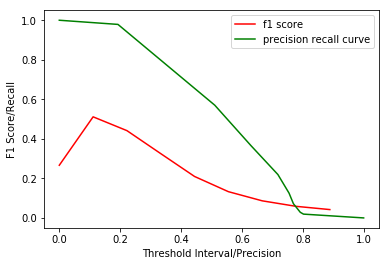

In [221]:
prefix = '/home/donghao/Desktop/donghao_v2/3D_Synthetic_Neuron/checkpoints/3d_unet_pixel/test_full'
prefix_gt = '/home/donghao/Desktop/donghao_v2/3D_Synthetic_Neuron/datasets/datasets/fly/test_crop'
allfiles = os.listdir(prefix)
threshold_array = np.linspace(start=0, stop=1, num=10)
for i, file in enumerate(allfiles):
    filepath = os.path.join(prefix, file)
    pred_im = loadtiff3d(filepath) / 255
    gt_filepath = from_predpath_to_gtpath(predpath=filepath, prefix_gt_input=prefix_gt)
    print(gt_filepath)
    gt_im = loadtiff3d(gt_filepath) / 255
    eva_metric_array = compute_interval_confusion(threshold_array_input=threshold_array,
                                                  gt_im_input=gt_im,
                                                  pred_im_input=pred_im)
    if i == 0:
        eva_metric_all = eva_metric_array
    else:
        eva_metric_all = eva_metric_all + eva_metric_array
eva_metric_all = eva_metric_all / (i + 1)
from_metric_to_testcurve(eva_metric_all_input=eva_metric_all)

8_fake_B.tif is being processed
0.09058773058773059 0.9711184694628403 0.16571706612672854 5279 157 52996


/home/donghao/anaconda3/envs/cvprw4/lib/python3.5/site-packages/ipykernel/__main__.py:36: RuntimeWarning: invalid value encountered in double_scalars


7_fake_B.tif is being processed
0.18755642606846107 0.9670216962524655 0.3141773255068823 12257 418 53094
29_fake_B.tif is being processed
0.21595727076117163 0.973730252662996 0.3535115291743925 37845 1021 137398
3_fake_B.tif is being processed
0.16951613658719378 0.9602016449986734 0.2881598853411896 3619 150 17730
30_fake_B.tif is being processed
0.15312737515089195 0.9849737579984182 0.2650492856244619 13700 209 75768
14_fake_B.tif is being processed
0.22149846821926772 0.9802123552123552 0.3613440621082851 22341 451 78522
21_fake_B.tif is being processed
0.12223098513140498 0.9736696230598669 0.21719596892195456 10539 285 75683
36_fake_B.tif is being processed
0.24316905487420987 0.9826989619377162 0.3898657514888463 9656 170 30053
2_fake_B.tif is being processed
0.10409044464220969 0.9604622871046229 0.1878252594641211 3158 130 27181
17_fake_B.tif is being processed
0.17346619217081852 0.982741935483871 0.2948820326678766 6093 107 29032
19_fake_B.tif is being processed
0.20903437

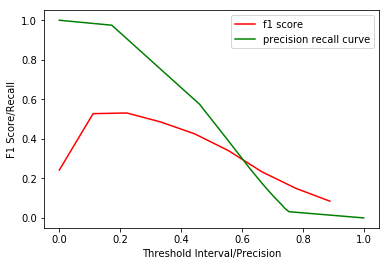

In [222]:
# find the best threshold from training files 
prefix = '/home/donghao/Desktop/donghao_v2/3D_Synthetic_Neuron/checkpoints/3d_unet_pixel/train_full'
prefix_gt = '/home/donghao/Desktop/donghao_v2/3D_Synthetic_Neuron/datasets/datasets/fly/test_crop'
allfiles = os.listdir(prefix)
threshold_array = np.linspace(start=0, stop=1, num=10)
for i, file in enumerate(allfiles):
    print(file, 'is being processed')
    filepath = os.path.join(prefix, file)
    pred_im = loadtiff3d(filepath) / 255
    gt_filepath = from_predpath_to_gtpath(predpath=filepath, prefix_gt_input=prefix_gt)
    gt_im = loadtiff3d(gt_filepath) / 255
    eva_metric_array = compute_interval_confusion(threshold_array_input=threshold_array,
                                                  gt_im_input=gt_im,
                                                  pred_im_input=pred_im)
    if i == 0:
        eva_metric_all = eva_metric_array
    else:
        eva_metric_all = eva_metric_all + eva_metric_array
eva_metric_all = eva_metric_all / (i + 1)
from_metric_to_testcurve(eva_metric_all_input=eva_metric_all)